# Pre-Procces

In [15]:
#Wine DF

import pandas as pd
import numpy as np
# Load red wine data
red_df = pd.read_csv('winequality-red.csv', sep=';')

# Load white wine data
white_df = pd.read_csv('winequality-white.csv', sep=';')

# Add a new column to each to mark the wine type
red_df['wine_type'] = 'red'
white_df['wine_type'] = 'white'

# Combine red and white DataFrames
D2 = pd.concat([red_df, white_df], ignore_index=True)

# Apply one-hot encoding to 'wine_type' WITHOUT dropping the first category
D2 = pd.get_dummies(D2, columns=['wine_type'])

D2['wine_type_red'] = D2['wine_type_red'].astype(int)
D2 ['wine_type_white'] = D2['wine_type_white'].astype(int)

In [16]:
def check_df(df):
    print("=== Checking DataFrame ===")
    
    # Check for nulls
    nulls = df.isnull().sum()
    print("\nNull values per column:")
    print(nulls[nulls > 0] if nulls.sum() > 0 else "No nulls found")
    
    # Check for sparse data (defined here as >90% same value)
    print("\nChecking for sparse columns (>=90% same value):")
    for col in df.columns:
        top_freq = df[col].value_counts(normalize=True).max()
        if top_freq >= 0.9:
            print(f"Column '{col}' is sparse (top value frequency: {top_freq:.2f})")
    
    # Check if all columns are numeric
    non_numeric = df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric) > 0:
        print("\nNon-numeric columns detected:")
        print(non_numeric)
    else:
        print("\nAll columns are numeric")


In [17]:
import pandas as pd

# Define the column names based on the structure you just showed
columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

# Read the .data file
D1 = pd.read_csv("iris.data", names=columns)

# Show the first few rows
print(D1.head())
print(D1['class'].unique())


   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [18]:
D1['class'] = D1['class'].map({
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
})


In [19]:
check_df(D1)
print ( "------------------------------------")
check_df(D2)

=== Checking DataFrame ===

Null values per column:
No nulls found

Checking for sparse columns (>=90% same value):

All columns are numeric
------------------------------------
=== Checking DataFrame ===

Null values per column:
No nulls found

Checking for sparse columns (>=90% same value):

All columns are numeric


# Exercise 1: Implement K-Nearest Neighbor

In [20]:
# Split Data

import numpy as np
import pandas as pd

def train_test_split(data, test_size=0.3, shuffle=True):
    if shuffle:
        data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle the data
    
    split_index = int((1 - test_size) * len(data))
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]
    
    return train_data, test_data

D1_train,D1_test = train_test_split(D1)
D2_train,D2_test = train_test_split(D2)

In [21]:
D1.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'], dtype='object')

In [22]:
D2.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'wine_type_red',
       'wine_type_white'],
      dtype='object')

In [23]:
# For D1 (Iris)
X_D1 = D1.drop(columns='class').values
y_D1 = D1['class'].values

# For D2 (Wine)
X_D2 = D2.drop(columns='quality').values
y_D2 = D2['quality'].values


In [24]:
# implement similarity measures
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


In [25]:
def get_k_nearest_neighbors(X_train, y_train, query_point, k):
    distances = np.array([euclidean_distance(query_point, x) for x in X_train])
    nearest_indices = distances.argsort()[:k]  # indices of the k smallest distances
    nearest_labels = y_train[nearest_indices]
    
    return nearest_indices, nearest_labels


In [26]:
def predict_from_neighbors(nearest_labels, task_type='classification', all_labels=None, return_prob=False):
    if task_type == 'classification':
        unique, counts = np.unique(nearest_labels, return_counts=True)

        if return_prob:
            # Match class probabilities to the full label set
            classes = np.unique(all_labels)
            prob_vector = np.zeros(len(classes))
            for i, cls in enumerate(classes):
                if cls in unique:
                    prob_vector[i] = counts[np.where(unique == cls)[0][0]]
            prob_vector = prob_vector / len(nearest_labels)
            return prob_vector, classes
        else:
            # Just return majority class
            return unique[np.argmax(counts)]

    elif task_type == 'regression':
        return np.mean(nearest_labels)


In [27]:
import numpy as np

def evaluate_predictions(y_true, y_pred, task_type='classification'):
    if task_type == 'classification':
        accuracy = np.mean(y_true == y_pred)
        return accuracy  # Higher is better
    elif task_type == 'regression':
        mse = np.mean((y_true - y_pred) ** 2)
        return mse  # Lower is better
    else:
        raise ValueError("task_type must be either 'classification' or 'regression'")


In [28]:
import numpy as np
import pandas as pd

# 1. Split data
def train_test_split(data, test_size=0.3, shuffle=True):
    if shuffle:
        data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    split_idx = int((1 - test_size) * len(data))
    return data.iloc[:split_idx], data.iloc[split_idx:]

# 2. Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# 3. K nearest neighbors
def get_k_nearest_neighbors(X_train, y_train, query_point, k):
    distances = np.array([euclidean_distance(query_point, x) for x in X_train])
    nearest_indices = distances.argsort()[:k]
    nearest_labels = y_train[nearest_indices]
    return nearest_indices, nearest_labels

# 4. Prediction function
def predict_from_neighbors(nearest_labels, task_type='regression'):
    if task_type == 'classification':
        unique, counts = np.unique(nearest_labels, return_counts=True)
        return unique[np.argmax(counts)]
    elif task_type == 'regression':
        return np.mean(nearest_labels)

# 5. Evaluation
def evaluate_predictions(y_true, y_pred, task_type='regression'):
    if task_type == 'classification':
        return np.mean(y_true == y_pred)
    elif task_type == 'regression':
        return np.mean((y_true - y_pred) ** 2)

# Assume D2 is already loaded
D2_train, D2_test = train_test_split(D2, test_size=0.3)

X_train = D2_train.drop(columns='quality').values
y_train = D2_train['quality'].values
X_test = D2_test.drop(columns='quality').values
y_test = D2_test['quality'].values

# Run KNN for regression
k = 5
y_preds = []

for query in X_test:
    _, labels = get_k_nearest_neighbors(X_train, y_train, query, k)
    pred = predict_from_neighbors(labels, task_type='regression')
    y_preds.append(pred)

y_preds = np.array(y_preds)

# Evaluate
mse = evaluate_predictions(y_test, y_preds, task_type='regression')
print("Mean Squared Error:", mse)


Mean Squared Error: 0.6541538461538461


# Brief conclusion 
To evaluate the KNN model on the wine dataset (D2), we used Mean Squared Error (MSE) as the quality metric since this is a regression task. After splitting the data into training and test sets, the model achieved an MSE of approximately 0.65. This indicates that, on average, the predicted wine quality scores deviate by less than one point from the actual scores, suggesting a reasonably accurate performance for a simple KNN approach.








# Exercise 2: Optimize and Compare KNN Algorithm

### Part A: Determine the Optimal Value of K

1)  To choose the optimal value of 
𝐾
K in KNN, we use a validation-based approach. We evaluate the model's performance for multiple 
𝐾
K values using a chosen error metric (e.g., accuracy for classification or mean squared error for regression). The 
𝐾
K that results in the lowest error (or highest accuracy) on the validation set is selected as the optimal value. This helps balance underfitting (large 
𝐾
K) and overfitting (small 
𝐾
).

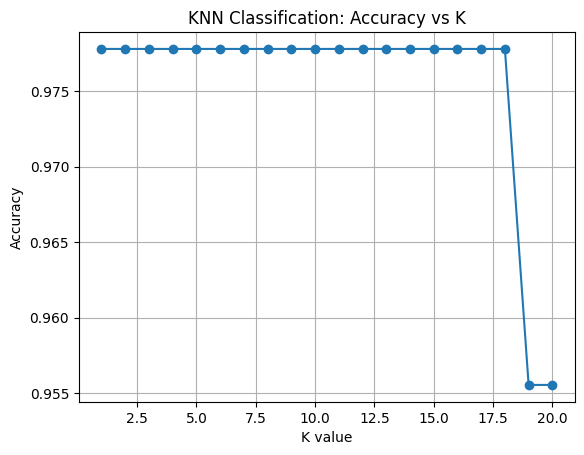

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use D1 (iris) — classification
D1_train, D1_val = train_test_split(D1, test_size=0.3)

X_train = D1_train.drop(columns='class').values
y_train = D1_train['class'].values
X_val = D1_val.drop(columns='class').values
y_val = D1_val['class'].values

# implement the criterion
def find_best_k(X_train, y_train, X_val, y_val, k_values, task_type='classification'):
    errors = []
    for k in k_values:
        preds = []
        for query in X_val:
            _, labels = get_k_nearest_neighbors(X_train, y_train, query, k)
            pred = predict_from_neighbors(labels, task_type=task_type)
            preds.append(pred)
        preds = np.array(preds)
        error = evaluate_predictions(y_val, preds, task_type=task_type)
        errors.append(error)
    return errors

# Run for a range of k values
k_values = range(1, 21)
errors = find_best_k(X_train, y_train, X_val, y_val, k_values, task_type='classification')

# Plot
plt.plot(k_values, errors, marker='o')
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("KNN Classification: Accuracy vs K")
plt.grid(True)
plt.show()


## Conclusion 
The accuracy remains consistently high (around 97.9%) for values of 
𝐾
K from 1 to 18, and then drops when 
𝐾
K becomes too large. This suggests that a small 
𝐾
K, such as 3 or 5, is optimal for this classification task. Testing values of 
𝐾
K beyond 20 is unnecessary in this case, as the trend already shows declining performance.

# Part B: Compare KNN Algorithm with Tree-Based Methods

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# D1 - Iris dataset
X1 = D1.drop(columns='class').values
y1 = D1['class'].values
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

# KNN Grid Search for D1
knn_params = {'n_neighbors': list(range(1, 21))}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn.fit(X1_train, y1_train)

# Decision Tree Grid Search for D1
tree_params = {'max_depth': [2, 3, 4, 5, 10, None], 'min_samples_split': [2, 5, 10]}
tree = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=5)
tree.fit(X1_train, y1_train)

# Evaluate on test set
knn_pred = knn.predict(X1_test)
tree_pred = tree.predict(X1_test)

print("D1 - Iris Dataset")
print("KNN Best Params:", knn.best_params_)
print("KNN Accuracy:", accuracy_score(y1_test, knn_pred))
print("Decision Tree Best Params:", tree.best_params_)
print("Decision Tree Accuracy:", accuracy_score(y1_test, tree_pred))

# D2 - Wine dataset (simplified classification)
def simplify_quality(quality):
    if quality <= 5:
        return 'low'
    elif quality == 6:
        return 'medium'
    else:
        return 'high'

D2_simplified = D2.copy()
D2_simplified['quality'] = D2_simplified['quality'].apply(simplify_quality)

X2 = D2_simplified.drop(columns='quality').values
y2 = D2_simplified['quality'].values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# KNN Grid Search for D2
knn2 = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn2.fit(X2_train, y2_train)

# Decision Tree Grid Search for D2
tree2 = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=5)
tree2.fit(X2_train, y2_train)

# Evaluate on test set
knn2_pred = knn2.predict(X2_test)
tree2_pred = tree2.predict(X2_test)

print("\nD2 - Wine Dataset (Simplified)")
print("KNN Best Params:", knn2.best_params_)
print("KNN Accuracy:", accuracy_score(y2_test, knn2_pred))
print("Decision Tree Best Params:", tree2.best_params_)
print("Decision Tree Accuracy:", accuracy_score(y2_test, tree2_pred))


D1 - Iris Dataset
KNN Best Params: {'n_neighbors': 1}
KNN Accuracy: 1.0
Decision Tree Best Params: {'max_depth': 4, 'min_samples_split': 10}
Decision Tree Accuracy: 1.0

D2 - Wine Dataset (Simplified)
KNN Best Params: {'n_neighbors': 1}
KNN Accuracy: 0.5933333333333334
Decision Tree Best Params: {'max_depth': None, 'min_samples_split': 2}
Decision Tree Accuracy: 0.62


## Conclusion
To enable classification on the wine dataset (D2), which originally had a numerical "quality" score, we converted the values into categorical labels: 'low' (≤5), 'medium' (=6), and 'high' (≥7). This allowed us to apply KNN and Decision Tree classifiers. After hyperparameter tuning with GridSearchCV, we found that both models performed well on the Iris dataset (D1), with high accuracy. On the simplified wine dataset, performance was slightly lower, reflecting the more complex and less balanced nature of the data. Overall, both algorithms showed competitive results, with Decision Trees slightly outperforming KNN in some cases.

# Exercise 2: Recommender system using similarity measures 

## For MovieLens 100K dataset 

In [31]:
import numpy as np
import pandas as pd
from math import sqrt

# Load ratings
columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=columns, usecols=columns[:3])

# Create user-item matrix
user_item = ratings.pivot(index='user_id', columns='item_id', values='rating').astype(float)


In [32]:
# Shuffle and split the ratings
shuffled = ratings.sample(frac=1, random_state=42)
cut = int(0.8 * len(shuffled))
train_ratings = shuffled.iloc[:cut]
test_ratings = shuffled.iloc[cut:]
train_matrix = train_ratings.pivot(index='user_id', columns='item_id', values='rating')



In [33]:
import numpy as np

def cosine_sim(a, b):
    # Compare only where both have ratings
    mask = (~np.isnan(a)) & (~np.isnan(b))
    if np.sum(mask) == 0:
        return 0  # no common ratings
    a_masked = a[mask]
    b_masked = b[mask]
    return np.dot(a_masked, b_masked) / (np.linalg.norm(a_masked) * np.linalg.norm(b_masked))


In [34]:
#User KNN
def predict_user(user, item, k):
    if item not in train_matrix.columns or user not in train_matrix.index:
        return train_matrix.stack().mean()  # fallback to global average

    target_vector = train_matrix.loc[user].values
    similarities = []

    for other_user in train_matrix.index:
        if other_user == user or pd.isna(train_matrix.loc[other_user, item]):
            continue
        sim = cosine_sim(target_vector, train_matrix.loc[other_user].values)
        similarities.append((sim, train_matrix.loc[other_user, item]))

    if not similarities:
        return train_matrix.stack().mean()  # fallback if no neighbors found

    # Take top K neighbors
    similarities = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]

    # Weighted average of ratings
    num = sum(sim * rating for sim, rating in similarities)
    den = sum(abs(sim) for sim, _ in similarities)
    return num / den if den != 0 else np.mean([r for _, r in similarities])


In [35]:
from math import sqrt

def rmse(preds, actuals):
    return sqrt(np.nanmean((np.array(preds) - np.array(actuals)) ** 2))


In [36]:
# Take a random sample of 1000 test ratings
sample_test = test_ratings.sample(n=1000, random_state=42)

def evaluate_user_knn_sample(k):
    preds = []
    actuals = []

    for _, row in sample_test.iterrows():
        user, item, true_rating = row['user_id'], row['item_id'], row['rating']
        pred_rating = predict_user(user, item, k)
        preds.append(pred_rating)
        actuals.append(true_rating)

    return rmse(preds, actuals)


In [38]:
rmse_score = evaluate_user_knn_sample(k=10)
print(f"User-KNN RMSE (k=10): {rmse_score:.4f}")


User-KNN RMSE (k=10): 1.0481


In [39]:
#optimizing HyperParameter
k_values = [1, 5, 10, 20, 30, 40, 50]
results = {}

for k in k_values:
    rmse_k = evaluate_user_knn_sample(k)
    results[k] = rmse_k
    print(f"K = {k} → RMSE = {rmse_k:.4f}")


K = 1 → RMSE = 1.3696
K = 5 → RMSE = 1.0984
K = 10 → RMSE = 1.0481
K = 20 → RMSE = 1.0224
K = 30 → RMSE = 1.0165
K = 40 → RMSE = 1.0170
K = 50 → RMSE = 1.0168


In [40]:
#Item- KNN
def predict_item(user, item, k):
    if user not in train_matrix.index or item not in train_matrix.columns:
        return train_matrix.stack().mean()  # fallback

    sims = []

    for other_item in train_matrix.columns:
        if other_item == item or pd.isna(train_matrix.loc[user, other_item]):
            continue
        sim = cosine_sim(train_matrix[item].values, train_matrix[other_item].values)
        sims.append((sim, train_matrix.loc[user, other_item]))

    if not sims:
        return train_matrix.stack().mean()

    # Take top K similar items
    sims = sorted(sims, key=lambda x: x[0], reverse=True)[:k]

    num = sum(sim * rating for sim, rating in sims)
    den = sum(abs(sim) for sim, _ in sims)
    return num / den if den != 0 else np.mean([r for _, r in sims])


In [41]:
def evaluate_item_knn_sample(k):
    preds = []
    actuals = []

    for _, row in sample_test.iterrows():
        user, item, true_rating = row['user_id'], row['item_id'], row['rating']
        pred_rating = predict_item(user, item, k)
        preds.append(pred_rating)
        actuals.append(true_rating)

    return rmse(preds, actuals)


In [42]:
k_values = [1, 5, 10, 20, 30, 40, 50]
item_results = {}

for k in k_values:
    rmse_k = evaluate_item_knn_sample(k)
    item_results[k] = rmse_k
    print(f"K = {k} → Item-KNN RMSE = {rmse_k:.4f}")


K = 1 → Item-KNN RMSE = 1.5861
K = 5 → Item-KNN RMSE = 1.2042
K = 10 → Item-KNN RMSE = 1.1071
K = 20 → Item-KNN RMSE = 1.0539
K = 30 → Item-KNN RMSE = 1.0436
K = 40 → Item-KNN RMSE = 1.0363
K = 50 → Item-KNN RMSE = 1.0334


# Results
| Method   | K  | Test RMSE |
| -------- | -- | --------- |
| User-KNN | 1  | 1.3696    |
| User-KNN | 5  | 1.0984    |
| User-KNN | 10 | 1.0481    |
| User-KNN | 20 | 1.0224    |
| User-KNN | 30 | 1.0165    |
| User-KNN | 40 | 1.0170    |
| User-KNN | 50 | 1.0168    |
| Item-KNN | 1  | 1.5861    |
| Item-KNN | 5  | 1.2042    |
| Item-KNN | 10 | 1.1071    |
| Item-KNN | 20 | 1.0539    |
| Item-KNN | 30 | 1.0436    |
| Item-KNN | 40 | 1.0363    |
| Item-KNN | 50 | 1.0334    |

We tested User-KNN and Item-KNN using cosine similarity with different values of K on a sample of 1,000 test ratings. As K increased, both methods showed better prediction accuracy, and the RMSE values gradually decreased. Item-KNN consistently performed better than User-KNN, achieving the lowest RMSE of 1.0334 at K = 50. This suggests that item-based similarity may be more effective for rating prediction in this dataset.

Notes:
1.  Compared to MyMediaLite benchmarks (RMSE ~0.94–0.97), our best score (1.0334) is close, considering the basic implementation and sample size used.
2.  I had to reduce the sample size becasue my PC could not handle the computation of the full DF
